## Setting

In [1]:
import pandas as pd

train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")
pd.set_option('display.max_columns', None)

train.shape, test.shape

((20000, 23), (10000, 22))

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import font_manager, rc

f_path = 'C:\Windows\Fonts\malgun.ttf'
font_manager.FontProperties(fname=f_path).get_name()

from matplotlib import rc
rc('font', family='Malgun Gothic')

## 문제
개인적 특성을 바탕으로 한 데이터를 활용하여 **소득 수준을 예측**하는 것을 목표로 한다.
다양한 개인적 특성 데이터를 분석하고 이해하는 능력을 키우며, 이를 통해 ai 역량과 경험을 발전시키는 것

<br>

개인의 특성과 관련된 다양한 데이터를 활용하여 개인 소득 수준을 예측할 수 있는 AI 모델 개발


### Train dataset EDA

In [3]:
train.columns.symmetric_difference(test.columns)

Index(['Income'], dtype='object')

- 종속변수 'Income'

- isnull().sum() 결과 train, test 모두 NaN 값 없음

In [4]:
train.head()

,ID,Age,Gender,Education_Status,Employment_Status,Working_Week (Yearly),Industry_Status,Occupation_Status,Race,Hispanic_Origin,Martial_Status,Household_Status,Household_Summary,Citizenship,Birth_Country,Birth_Country (Father),Birth_Country (Mother),Tax_Status,Gains,Losses,Dividends,Income_Status,Income
0,TRAIN_00000,63,M,Middle (7-8),Full-Time,4,Social Services,Services,White,All other,Married,Householder,Householder,Native,US,US,US,Nonfiler,0,0,0,Unknown,425
1,TRAIN_00001,37,M,Associates degree (Vocational),Full-Time,52,Entertainment,Services,White,All other,Separated,Nonfamily householder,Householder,Native,US,US,US,Single,0,0,0,Under Median,0
2,TRAIN_00002,58,F,High graduate,Full-Time,52,Manufacturing (Non-durable),Admin Support (include Clerical),Black,All other,Married,Householder,Householder,Native,US,US,US,Married Filling Jointly both under 65 (MFJ),3411,0,0,Under Median,860
3,TRAIN_00003,44,M,High graduate,Full-Time,52,Retail,Technicians & Support,White,All other,Divorced,Nonfamily householder,Householder,Native,US,US,US,Single,0,0,0,Under Median,850
4,TRAIN_00004,37,F,High graduate,Full-Time,52,Retail,Sales,White,All other,Divorced,Householder,Householder,Native,US,US,US,Head of Household (HOH),0,0,0,Unknown,570


In [5]:
#하나씩 살펴보자
#(1) 수치형 

train.describe()

,Age,Working_Week (Yearly),Gains,Losses,Dividends,Income
count,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000
mean,35.632500,34.943050,383.129500,40.202150,123.451450,554.565250
std,17.994414,22.254592,4144.247487,279.182677,1206.949429,701.553155
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,23.000000,7.000000,0.000000,0.000000,0.000000,0.000000
50%,34.000000,52.000000,0.000000,0.000000,0.000000,500.000000
75%,47.000000,52.000000,0.000000,0.000000,0.000000,875.000000
max,90.000000,52.000000,99999.000000,4356.000000,45000.000000,9999.000000


In [6]:
#EDA 함수

def eda_box(value): #박스플롯, 수치형
    plt.figure(figsize=(10,4))
    sns.boxplot(value, palette='Set1')
    plt.xticks(rotation=45)
    plt.show()

def eda_bar(value): #바 플롯, 범주형
    plt.figure(figsize=(10,4))
    sns.barplot(value, palette='Set1')
    plt.xticks(rotation=45)
    plt.show()   

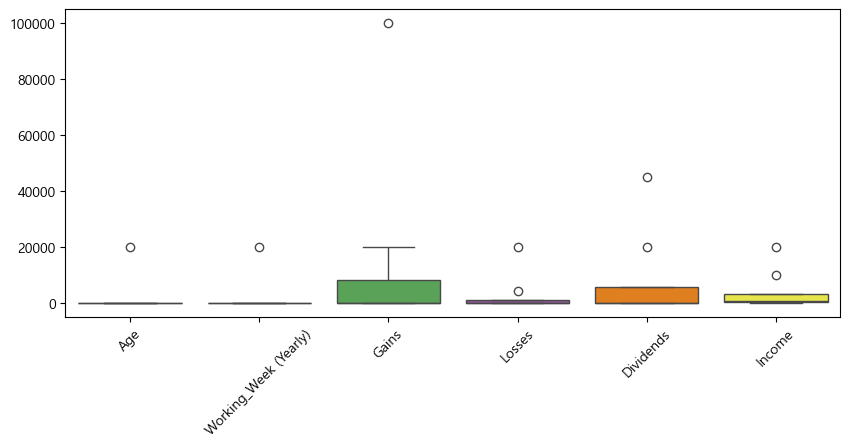

In [7]:
#수치형 describe
eda_box(train.describe())

수치형이 각각 이상치가 있는 상황으로 확인 후 전처리가 필요한 상황

C:\Users\sori4\AppData\Local\Temp\ipykernel_15056\1487583316.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(value, palette='Set1')


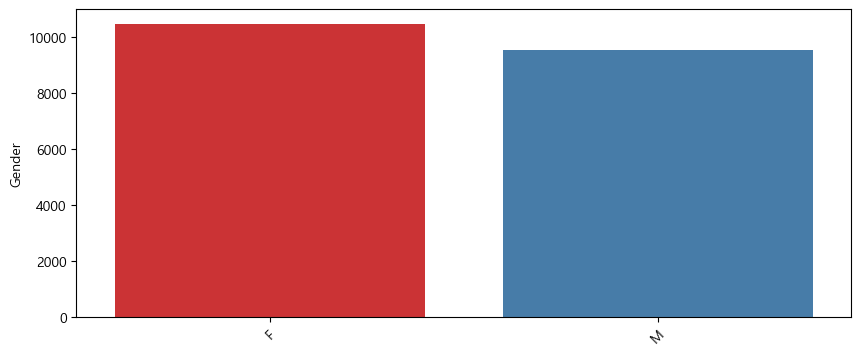

In [8]:
#(2) 성별
eda_bar(train['Gender'].value_counts())

In [9]:
# (3) Education_Status
train['Education_Status'].unique()

array(['Middle (7-8)', 'Associates degree (Vocational)', 'High graduate',
       'Masters degree', 'Bachelors degree', 'High Freshman',
       'Elementary (1-4)', 'College', 'Children', 'High Sophomore',
       'Associates degree (Academic)', 'High Junior', 'Elementary (5-6)',
       'Doctorate degree', 'Professional degree', 'High Senior',
       'Kindergarten'], dtype=object)

<Axes: ylabel='Education_Status'>

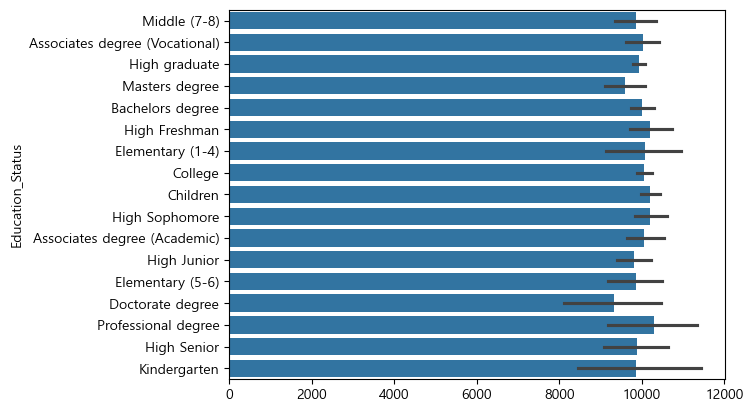

In [10]:
sns.barplot(train['Education_Status'])

**Education_Status 분류가 다양해서 상위 분류로 묶어서 인코딩 진행** <br>
<br>
- 유치원 이하 : Children, Kindergarten
- 초등학교 : Elementary(1-4), Elementary(5-6)
- 중고등학교 : High graduate, High Freshman, High Junior, High Sophomore, Middle(7-8), High Senior
- 대학교(학사, 준학사) : Bachelors degree, Associates degree(Vocational), College, Associates degree(Academic)
- 대학원(석사, 박사, 전문학사) : Master degree, Doctorate degree, Professional degree

C:\Users\sori4\AppData\Local\Temp\ipykernel_15056\1487583316.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(value, palette='Set1')


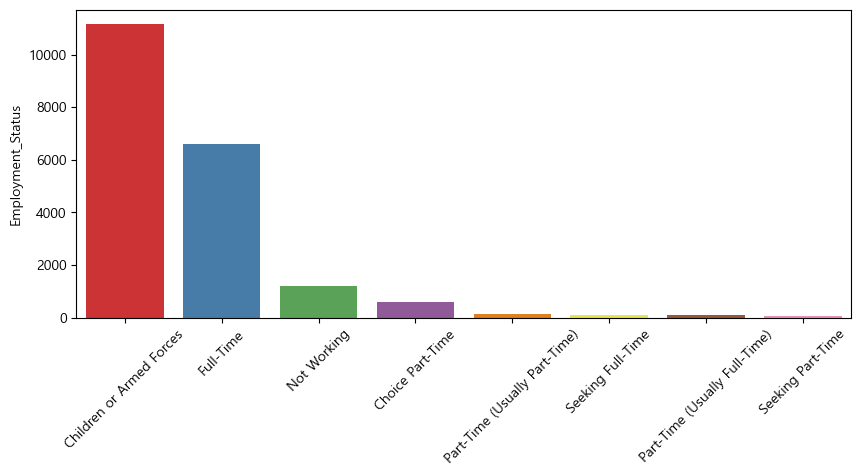

In [11]:
#(4) Employment_Status
eda_bar(train['Employment_Status'].value_counts())

In [12]:
train['Employment_Status'].value_counts()

Children or Armed Forces         11142
Full-Time                         6588
Not Working                       1221
Choice Part-Time                   593
Part-Time (Usually Part-Time)      158
Seeking Full-Time                  121
Part-Time (Usually Full-Time)      100
Seeking Part-Time                   77
Name: Employment_Status, dtype: int64

**Employment_Status (고용 형태) 상위 분류로 정리** 
<br>
- 'Children or Armed Forces'
- 'Full-Time'
- 'Not Working'
-  Part-Time : 'Choice Part-Time', 'Part-Time (Usually Part-Time)
- Between Jobs (구직 중) : 'Seeking Full-Time', 'Seeking Part-Time'

<BarContainer object of 24 artists>

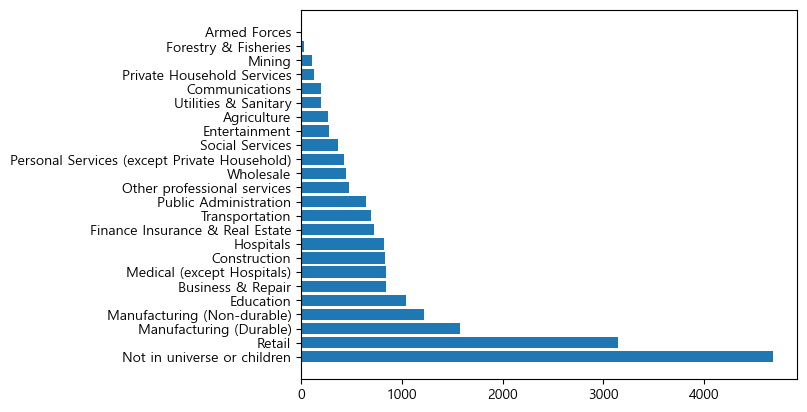

In [13]:
#(5) Industry_Status
industry_counts = train['Industry_Status'].value_counts()

# 수정된 코드
plt.barh(industry_counts.index, industry_counts.values)

In [14]:
industry_counts

Not in universe or children                     4688
Retail                                          3149
Manufacturing (Durable)                         1575
Manufacturing (Non-durable)                     1223
Education                                       1041
Business & Repair                                847
Medical (except Hospitals)                       838
Construction                                     832
Hospitals                                        821
Finance Insurance & Real Estate                  727
Transportation                                   693
Public Administration                            641
Other professional services                      477
Wholesale                                        450
Personal Services (except Private Household)     429
Social Services                                  367
Entertainment                                    278
Agriculture                                      268
Utilities & Sanitary                          

In [15]:
#(6) Occupation_Status
train['Occupation_Status'].value_counts()

Unknown                             4688
Admin Support (include Clerical)    2709
Services                            2313
Craft & Repair                      1869
Sales                               1692
Professional                        1488
Machine Operators & Inspectors      1383
Management                          1111
Handlers/Cleaners                    837
Transportation                       690
Technicians & Support                558
Farming & Forestry & Fishing         296
Protective Services                  260
Private Household Services           105
Armed Forces                           1
Name: Occupation_Status, dtype: int64

직업상태에서 unknown이 다수를 차지해 이에 대한 전처리가 필요 <br>
다른 것들과 상관관계를 통해 주부를 unknown으로 하는지 파악이 필요

C:\Users\sori4\AppData\Local\Temp\ipykernel_15056\1487583316.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(value, palette='Set1')


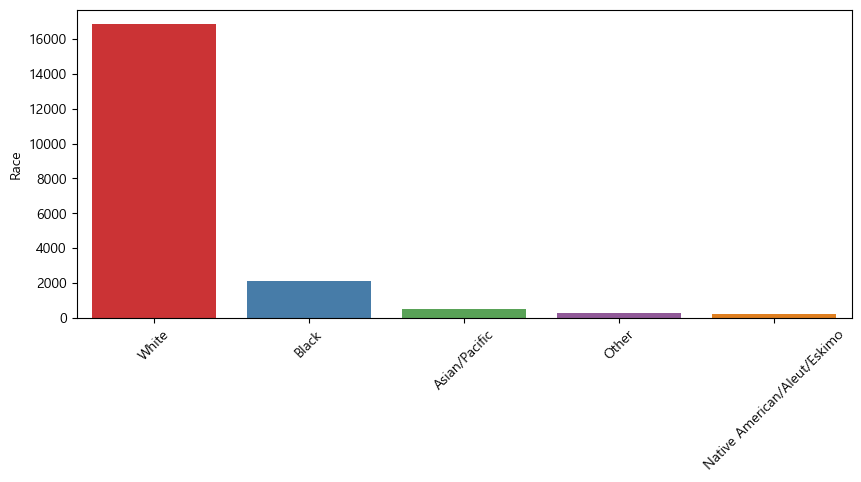

In [16]:
#(7) Race
eda_bar(train['Race'].value_counts())

In [17]:
#(8) Hispanic_Origin
train['Hispanic_Origin'].value_counts()

 All other                    17769
 Mexican-American               654
 Mexican (Mexicano)             624
 Central or South American      325
 Puerto Rican                   243
 Other Spanish                  201
 Cuban                           76
 NA                              59
 Chicano                         27
 Do not know                     22
Name: Hispanic_Origin, dtype: int64

hispanic_origin이 race와 상하위 관계로 예상되어 연관성이 어떻게 되는지 확인하고, 상관관계가 크지 않은지, 다중공선성은 없는지 파악이 필요

In [18]:
pd.crosstab(train['Race'], train['Hispanic_Origin'])

Hispanic_Origin,All other,Central or South American,Chicano,Cuban,Do not know,Mexican (Mexicano),Mexican-American,NA,Other Spanish,Puerto Rican
Race,,,,,,,,,,
Asian/Pacific,504,4,0,0,0,0,0,2,1,0
Black,2080,18,0,2,0,1,0,2,11,8
Native American/Aleut/Eskimo,214,0,0,0,0,8,3,0,1,0
Other,67,33,10,1,0,73,41,1,16,54
White,14904,270,17,73,22,542,610,54,172,181


In [19]:
import numpy as np
from scipy import stats
import statsmodels.api as sm

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    rcorr = r - ((r - 1) ** 2) / (n - 1)
    kcorr = k - ((k - 1) ** 2) / (n - 1)
    return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))

correlation = cramers_v(train['Race'], train['Hispanic_Origin'])
print(f"Cramer's V between Race and Hispanic_Origin: {correlation}")

Cramer's V between Race and Hispanic_Origin: 0.16136343655234947


Race와 Hispanic_Origin는 상관관계가 있으나 약한 것으로 추정

C:\Users\sori4\AppData\Local\Temp\ipykernel_15056\1487583316.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(value, palette='Set1')


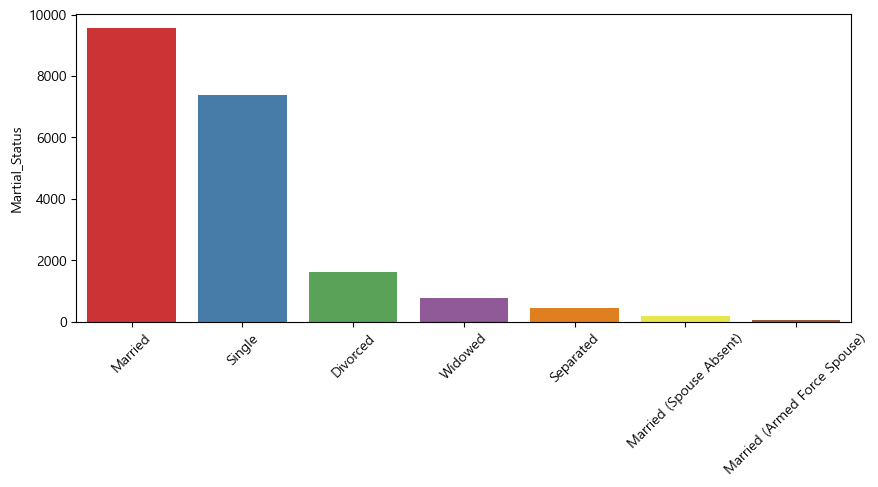

In [20]:
#(9) Martial_Status
eda_bar(train['Martial_Status'].value_counts())

**Martial_Status : Married를 하나로 합치는 전처리 필요**
<br>
- Martial_Status : Martial_Status 단어가 있으면 모두
- Single
- 결혼 경험 카테고리 생성 'Had been married' : 'Divored', 'Widowed', 'Separated'

In [21]:
train['Household_Status'].value_counts() #세대주

Householder                                                               6087
Spouse of householder                                                     4794
Child <18 never marr not in subfamily                                     2670
Nonfamily householder                                                     2465
Child 18+ never marr Not in a subfamily                                   1860
Secondary individual                                                       845
Other Rel 18+ never marr not in subfamily                                  195
Other Rel 18+ ever marr not in subfamily                                   154
Child 18+ ever marr Not in a subfamily                                     118
Child 18+ ever married Responsible Person of subfamily                     101
Child 18+ never married Responsible Person of subfamily                     96
Grandchild <18 never married child of subfamily Responsible Person          88
Responsible Person of unrelated subfamily           

In [22]:
train['Household_Status'].nunique()

31

In [23]:
train['Household_Summary'].value_counts()

Householder                             8552
Spouse of householder                   4794
Child under 18 never married            2679
Child 18 or older                       2192
Nonrelative of householder               974
Other relative of householder            781
Group Quarters- Secondary individual      24
Child under 18 ever married                4
Name: Household_Summary, dtype: int64

**Household_Status 삭제 summary으로 대체** 

In [24]:
train['Birth_Country'].unique()

array(['US', 'Cuba', 'Portugal', 'Mexico', 'Puerto-Rico', 'Germany',
       'Japan', 'Columbia', 'Philippines', 'Unknown', 'Italy',
       'Trinadad&Tobago', 'South Korea', 'Iran', 'England', 'India',
       'Vietnam', 'France', 'Scotland', 'Ecuador', 'China',
       'Outlying-U S (Guam USVI etc)', 'Nicaragua', 'Peru', 'Canada',
       'Jamaica', 'Dominican-Republic', 'Poland', 'Hong Kong', 'Thailand',
       'Cambodia', 'Guatemala', 'Laos', 'Yugoslavia', 'Haiti', 'Ireland',
       'El-Salvador', 'Panama', 'Honduras', 'Greece', 'Hungary', 'Taiwan',
       'Holand-Netherlands'], dtype=object)

In [25]:
train['Birth_Country (Father)'].unique()

array(['US', 'Cuba', 'Portugal', 'Mexico', 'Unknown', 'Puerto-Rico',
       'Germany', 'Japan', 'Poland', 'Columbia', 'Philippines', 'Italy',
       'Trinadad&Tobago', 'England', 'South Korea', 'Iran', 'France',
       'India', 'China', 'Dominican-Republic', 'Scotland', 'Ecuador',
       'Nicaragua', 'Peru', 'Cambodia', 'Canada', 'Jamaica', 'Vietnam',
       'Hong Kong', 'Thailand', 'Haiti', 'Guatemala', 'Laos',
       'Yugoslavia', 'Ireland', 'El-Salvador', 'Panama', 'Honduras',
       'Greece', 'Outlying-U S (Guam USVI etc)', 'Hungary', 'Taiwan',
       'Holand-Netherlands'], dtype=object)

In [26]:
print("Birth_Country 종류", train['Birth_Country'].nunique())
print("Birth_Country (Father) 종류", train['Birth_Country (Father)'].nunique())
print("Birth_Country (Mother) 종류", train['Birth_Country (Mother)'].nunique())

Birth_Country 종류 43
Birth_Country (Father) 종류 43
Birth_Country (Mother) 종류 43


**Birth_Country 태어난 국가가 43개로 US, Mid-South America, East Asia, Africa, Europe, South Asia 등으로 상위 분류 진행**
<br>
- North America : 'US', 'Outlying-U S (Guam USVI etc)', 'Canada',
- Mid-South America : 'Cuba',  'Mexico', 'Puerto-Rico', 'Columbia', 'Trinadad&Tobago', 'Ecuador', 'Nicaragua', 'Peru', 'Jamaica', 'Dominican-Republic', 'Haiti', 'Guatemala', 'El-Salvador', 'Panama', 'Honduras'
- East Asia : 'Japan', 'South Korea', 'China', 'Hong Kong', 'Taiwan'
- Europe : 'Portugal', 'Germany', 'Italy', 'England', 'France', 'Scotland', 'Poland', 'Yugoslavia', 'Ireland', 'Greece', 'Hungary'
- South Asia : 'Philippines', 'India', 'Vietnam', 'Cambodia', 'Laos', 'Thailand'
- Mideel East : 'Iran'
- Unknown

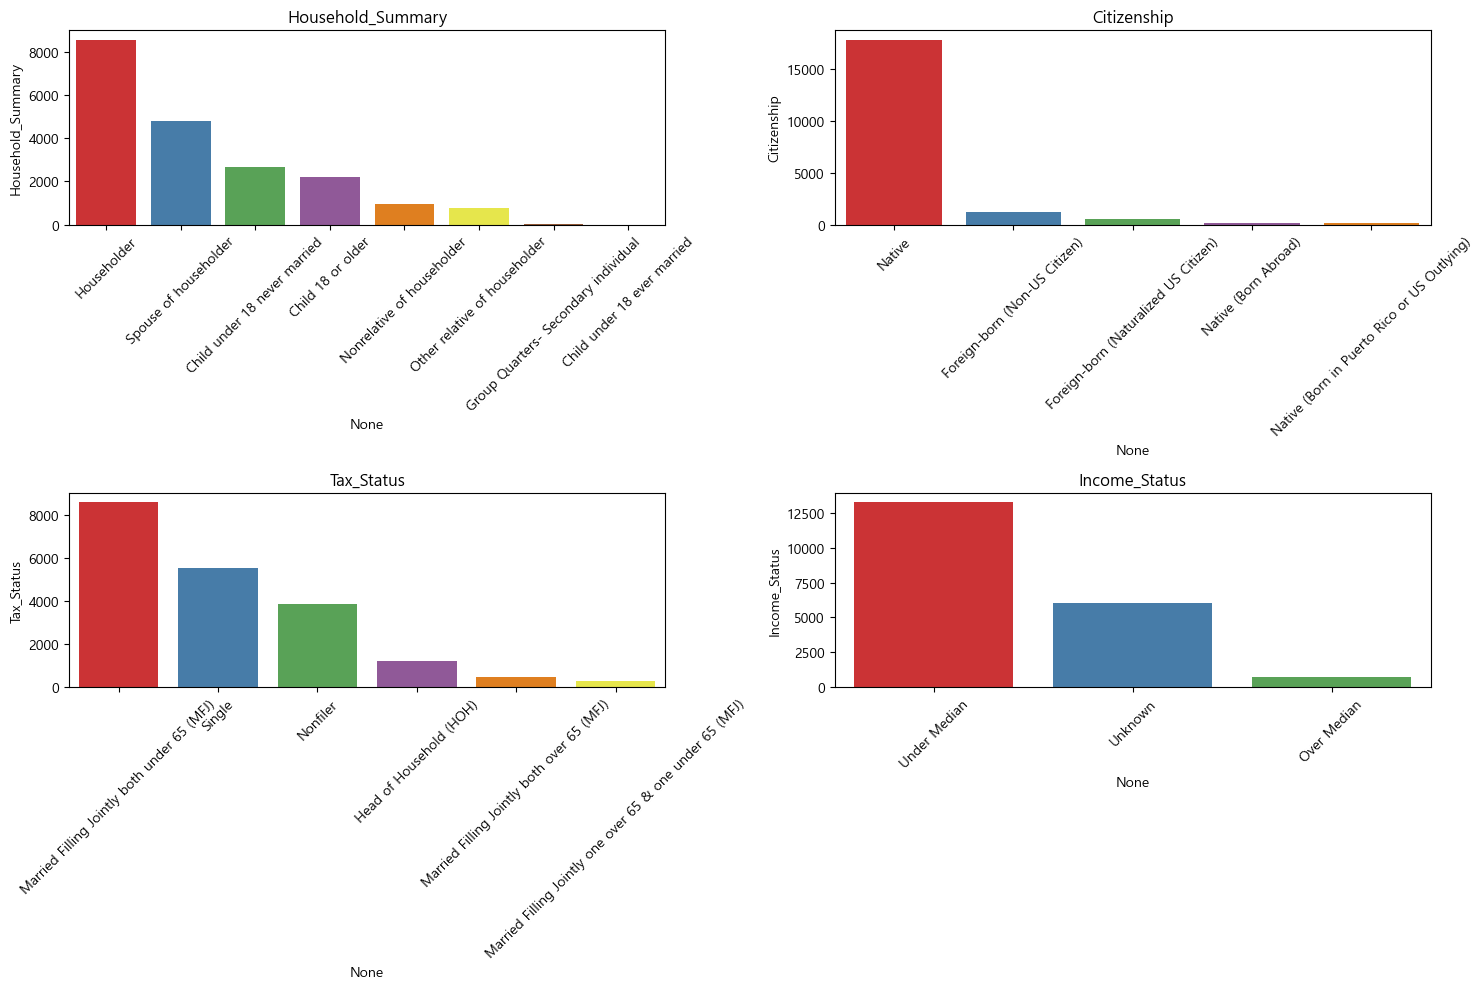

In [27]:
#(10) Industry_Status
f,ax = plt.subplots(2,2, figsize=(15,10))
lst = ['Household_Summary', 'Citizenship', 'Tax_Status', 'Income_Status']

for idx, feature in enumerate(lst):
    i = idx // 2  # subplot의 행 인덱스 계산 : 몫
    j = idx % 2   # subplot의 열 인덱스 계산 : 나머지
    sns.barplot(x=train[feature].value_counts().index, y=train[feature].value_counts(), hue=train[feature].value_counts().index, palette='Set1', ax=ax[i, j], legend=False)
    ax[i, j].tick_params(axis='x', rotation=45)
    ax[i, j].set_title(feature)  # subplot의 제목 설정

plt.tight_layout()  # subplot 간의 간격 조정
plt.show()

In [28]:
train['Occupation_Status'].value_counts()

Unknown                             4688
Admin Support (include Clerical)    2709
Services                            2313
Craft & Repair                      1869
Sales                               1692
Professional                        1488
Machine Operators & Inspectors      1383
Management                          1111
Handlers/Cleaners                    837
Transportation                       690
Technicians & Support                558
Farming & Forestry & Fishing         296
Protective Services                  260
Private Household Services           105
Armed Forces                           1
Name: Occupation_Status, dtype: int64

In [29]:
train['Industry_Status'].value_counts()

Not in universe or children                     4688
Retail                                          3149
Manufacturing (Durable)                         1575
Manufacturing (Non-durable)                     1223
Education                                       1041
Business & Repair                                847
Medical (except Hospitals)                       838
Construction                                     832
Hospitals                                        821
Finance Insurance & Real Estate                  727
Transportation                                   693
Public Administration                            641
Other professional services                      477
Wholesale                                        450
Personal Services (except Private Household)     429
Social Services                                  367
Entertainment                                    278
Agriculture                                      268
Utilities & Sanitary                          

In [30]:
train['Tax_Status'].value_counts() #미국 세금 관련 내용을 보고 도메인 파악하기

Married Filling Jointly both under 65 (MFJ)                 8588
Single                                                      5547
Nonfiler                                                    3874
Head of Household (HOH)                                     1217
Married Filling Jointly both over 65 (MFJ)                   469
Married Filling Jointly one over 65 & one under 65 (MFJ)     305
Name: Tax_Status, dtype: int64

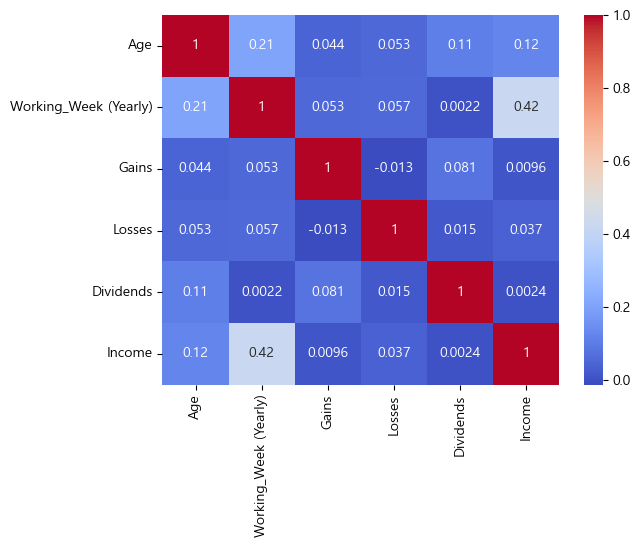

In [31]:
## 상관관계 확인
sns.heatmap(train.corr(), annot=True, cmap='coolwarm')
plt.show()

일하는 시간과 소득의 연관관계가 0.42로 높은 편이다.

### test dataset EDA

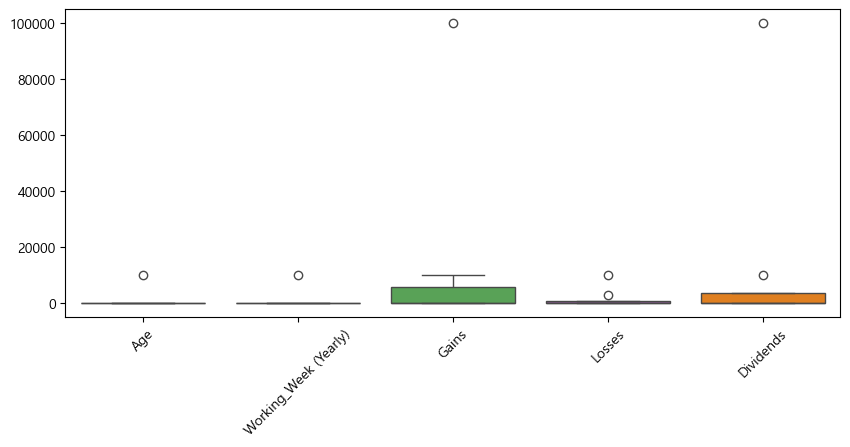

In [32]:
eda_box(test.describe())

In [33]:
test[test['Gains'] == test['Gains'].max()] # 99999가 18개

,ID,Age,Gender,Education_Status,Employment_Status,Working_Week (Yearly),Industry_Status,Occupation_Status,Race,Hispanic_Origin,Martial_Status,Household_Status,Household_Summary,Citizenship,Birth_Country,Birth_Country (Father),Birth_Country (Mother),Tax_Status,Gains,Losses,Dividends,Income_Status
489,TEST_0489,45,M,Bachelors degree,Full-Time,52,Entertainment,Management,White,All other,Single,Nonfamily householder,Householder,Native,US,US,US,Single,99999,0,0,Over Median
492,TEST_0492,30,M,High graduate,Children or Armed Forces,52,Retail,Transportation,White,Puerto Rican,Married,Householder,Householder,Native,US,Puerto-Rico,Puerto-Rico,Married Filling Jointly both under 65 (MFJ),99999,0,0,Over Median
1490,TEST_1490,32,M,Bachelors degree,Children or Armed Forces,52,Manufacturing (Durable),Sales,White,All other,Married,Householder,Householder,Native,US,US,US,Married Filling Jointly both under 65 (MFJ),99999,0,0,Over Median
1873,TEST_1873,22,M,College,Children or Armed Forces,52,Finance Insurance & Real Estate,Sales,Black,All other,Single,Child 18+ never marr Not in a subfamily,Child 18 or older,Native,US,US,US,Single,99999,0,0,Over Median
2956,TEST_2956,40,M,Doctorate degree,Full-Time,52,Medical (except Hospitals),Professional,White,All other,Married,Householder,Householder,Native,US,US,US,Married Filling Jointly both under 65 (MFJ),99999,0,341,Unknown
3077,TEST_3077,28,F,High graduate,Children or Armed Forces,52,Retail,Admin Support (include Clerical),White,All other,Married,Householder,Householder,Native,US,US,US,Married Filling Jointly both under 65 (MFJ),99999,0,0,Under Median
4309,TEST_4309,37,F,Associates degree (Academic),Children or Armed Forces,52,Hospitals,Professional,Black,All other,Married,Householder,Householder,Foreign-born (Non-US Citizen),Unknown,Unknown,Unknown,Married Filling Jointly both under 65 (MFJ),99999,0,0,Over Median
4585,TEST_4585,51,M,Bachelors degree,Children or Armed Forces,52,Transportation,Management,White,Mexican (Mexicano),Married,Householder,Householder,Foreign-born (Non-US Citizen),Mexico,Mexico,Mexico,Married Filling Jointly both under 65 (MFJ),99999,0,136,Over Median
6622,TEST_6622,45,F,Masters degree,Full-Time,52,Social Services,Professional,White,All other,Married,Householder,Householder,Native,US,US,US,Married Filling Jointly both under 65 (MFJ),99999,0,1932,Under Median
6831,TEST_6831,41,F,High graduate,Full-Time,52,Transportation,Management,White,All other,Married,Other Relative 18+ ever married Responsible Pe...,Other relative of householder,Native,US,US,US,Married Filling Jointly both under 65 (MFJ),99999,0,0,Under Median


In [34]:
test[test['Dividends'] == test['Dividends'].max()] #99999가 1개

,ID,Age,Gender,Education_Status,Employment_Status,Working_Week (Yearly),Industry_Status,Occupation_Status,Race,Hispanic_Origin,Martial_Status,Household_Status,Household_Summary,Citizenship,Birth_Country,Birth_Country (Father),Birth_Country (Mother),Tax_Status,Gains,Losses,Dividends,Income_Status
2811,TEST_2811,75,F,Bachelors degree,Children or Armed Forces,0,Not in universe or children,Unknown,White,All other,Widowed,Nonfamily householder,Householder,Native,US,US,US,Single,0,0,99999,Over Median


### 미국 Tax에 대한 이해

## 전처리

- 나이의 최대값은 90, 0.75가 41세, 0.95가 81세로 이상치라고 판단하지 않아서 전처리를 진행하지 않았다.
- 'Working_Week (Yearly)'은 boxplot 상 이상치로 예측되는 값 없어 진행하지 않음
- Gain에서 수익이 9999인 데이터가 30개 있음. 이상치로 판단하여 삭제
- Losses에서는 boxplot 상 큰 이상치로 판단하는 데이터가 없어 진행하지 않았다.
- Dividends 좀더 지켜보기
- Income에서 9999을 이상치로 판단하여 삭제

### 수치형 전처리

In [35]:
train.describe()

,Age,Working_Week (Yearly),Gains,Losses,Dividends,Income
count,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000
mean,35.632500,34.943050,383.129500,40.202150,123.451450,554.565250
std,17.994414,22.254592,4144.247487,279.182677,1206.949429,701.553155
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,23.000000,7.000000,0.000000,0.000000,0.000000,0.000000
50%,34.000000,52.000000,0.000000,0.000000,0.000000,500.000000
75%,47.000000,52.000000,0.000000,0.000000,0.000000,875.000000
max,90.000000,52.000000,99999.000000,4356.000000,45000.000000,9999.000000


In [36]:
#Gains 이상치 삭제1 : 30개 삭제
train.drop(index = train[train['Gains'] == train['Gains'].max()].index, inplace=True)

#Income 이상치 삭제1 : 1개 삭제
train.drop(index = train[train['Income'] == train['Income'].max()].index, inplace=True)

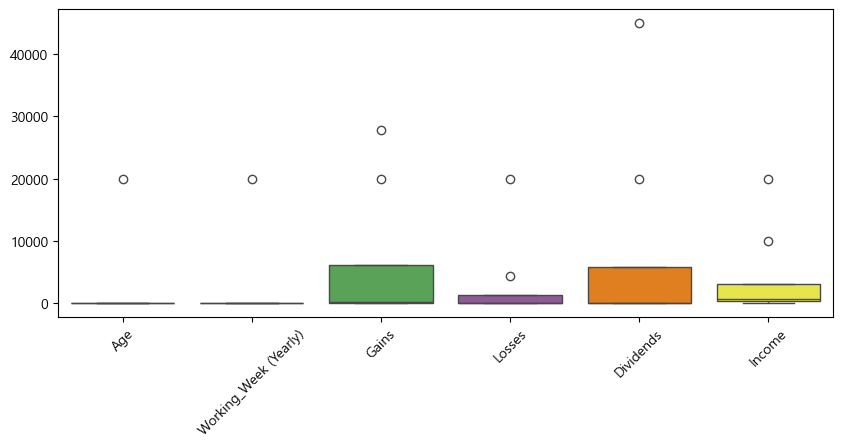

In [37]:
eda_box(train.describe())

In [38]:
train[train['Dividends'] == train['Dividends'].max()]
#배당금 가격이 월등히 큰 것을 제외하고는 큰 이상치가 없다고 판단하여 일시보류

,ID,Age,Gender,Education_Status,Employment_Status,Working_Week (Yearly),Industry_Status,Occupation_Status,Race,Hispanic_Origin,Martial_Status,Household_Status,Household_Summary,Citizenship,Birth_Country,Birth_Country (Father),Birth_Country (Mother),Tax_Status,Gains,Losses,Dividends,Income_Status,Income
401,TRAIN_00401,74,F,High Senior,Full-Time,48,Medical (except Hospitals),Professional,White,All other,Married,Spouse of householder,Spouse of householder,Native,US,US,US,Married Filling Jointly both over 65 (MFJ),0,0,45000,Over Median,500


Income이 0인 값들에 대해서 고민이 필요 하위 25%는 income이 0임

In [39]:
income_zero = train[train['Income'] == 0]

In [40]:
len(income_zero[income_zero['Gains'] != 0]) #296 #gains가 0인데 income이 zero일 수 있나?
len(income_zero[income_zero['Dividends'] != 0]) #869

869

### Test dataset 수치형 전처리

In [41]:
#Gains 이상치 삭제1 
test.drop(index = test[test['Gains'] == test['Gains'].max()].index, inplace=True)

#Dividends 이상치 삭제1
test.drop(index = test[test['Dividends'] == test['Dividends'].max()].index, inplace=True)

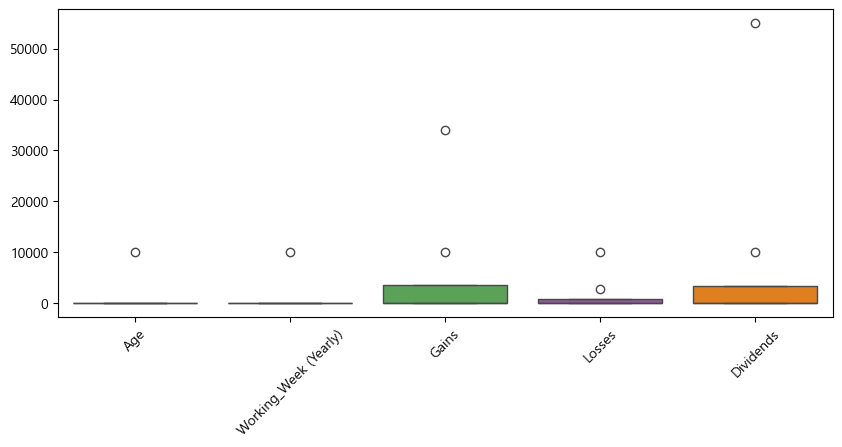

In [42]:
eda_box(test.describe())

### 범주형 전처리

In [43]:
len(train) #19970
len(test) #9981

9981

In [44]:
#종속값 분리
y = train[['Income']]

In [45]:
#데이터셋을 합쳐서 범주형 전처리 진행
data = pd.concat([train, test], axis=0)

In [46]:
#Education_Status 분류
def changing_data(column, value, change_value):
    data.loc[data[column] == value, column] = change_value

#유치원 이하 : Children, Kindergarten
changing_data('Education_Status', 'Kindergarten', 'Never_edu')
changing_data('Education_Status', 'Children', 'Never_edu')

# 초등학교 : Elementary (1-4), Elementary (5-6)
changing_data('Education_Status', 'Elementary (1-4)', 'Elementary')
changing_data('Education_Status', 'Elementary (5-6)', 'Elementary')

# 중고등학교 : High graduate, High Freshman, High Junior, High Sophomore, Middle(7-8), High Senior
changing_data('Education_Status', 'High graduate', 'Middle-High')
changing_data('Education_Status', 'High Freshman', 'Middle-High')
changing_data('Education_Status', 'High Junior', 'Middle-High')
changing_data('Education_Status', 'High Sophomore', 'Middle-High')
changing_data('Education_Status', 'Middle (7-8)', 'Middle-High')
changing_data('Education_Status', 'High Senior', 'Middle-High')

# 대학교(학사, 준학사) : Bachelors degree, Associates degree(Vocational), College, Associates degree(Academic)
changing_data('Education_Status', 'Bachelors degree', 'College')
changing_data('Education_Status', 'Associates degree (Vocational)', 'College')
changing_data('Education_Status', 'Associates degree (Academic)', 'College')

# 대학원(석사, 박사, 전문학사) : Master degree, Doctorate degree, Professional degree
changing_data('Education_Status', 'Masters degree', 'Graduate')
changing_data('Education_Status', 'Doctorate degree', 'Graduate')
changing_data('Education_Status', 'Professional degree', 'Graduate')

In [47]:
#고용형태 분류

#파트타임
changing_data('Employment_Status', 'Choice Part-Time', 'Part-Time')
changing_data('Employment_Status', 'Part-Time (Usually Part-Time)', 'Part-Time')
changing_data('Employment_Status', 'Part-Time (Usually Full-Time)', 'Part-Time')

#구직 중
changing_data('Employment_Status', 'Seeking Full-Time', 'Between Jobs')
changing_data('Employment_Status', 'Seeking Part-Time', 'Between Jobs')

In [48]:
#결혼여부
data['Martial_Status'] = data['Martial_Status'].apply(lambda x: 'Married' if 'married' in x.lower() else x)
changing_data('Martial_Status', 'Divorced', 'Have been married')
changing_data('Martial_Status', 'Widowed', 'Have been married')
changing_data('Martial_Status', 'Separated', 'Have been married')

In [49]:
#출생국가 확인
#북아메리카
changing_data('Birth_Country', 'US', 'North America')
changing_data('Birth_Country', 'Outlying-U S (Guam USVI etc)', 'North America')
changing_data('Birth_Country', 'Canada', 'North America')

#중남미
changing_data('Birth_Country', 'Cuba', 'Latin America')
changing_data('Birth_Country', 'Mexico', 'Latin America')
changing_data('Birth_Country', 'Puerto-Rico', 'Latin America')
changing_data('Birth_Country', 'Columbia', 'Latin America')
changing_data('Birth_Country', 'Trinadad&Tobago', 'Latin America')
changing_data('Birth_Country', 'Ecuador', 'Latin America')
changing_data('Birth_Country', 'Nicaragua', 'Latin America')
changing_data('Birth_Country', 'Peru', 'Latin America')
changing_data('Birth_Country', 'Jamaica', 'Latin America')
changing_data('Birth_Country', 'Dominican-Republic', 'Latin America')
changing_data('Birth_Country', 'Haiti', 'Latin America')
changing_data('Birth_Country', 'Guatemala', 'Latin America')
changing_data('Birth_Country', 'El-Salvador', 'Latin America')
changing_data('Birth_Country', 'Panama', 'Latin America')
changing_data('Birth_Country', 'Honduras', 'Latin America')

#동아시아
changing_data('Birth_Country', 'Japan', 'East Asia')
changing_data('Birth_Country', 'South Korea', 'East Asia')
changing_data('Birth_Country', 'China', 'East Asia')
changing_data('Birth_Country', 'Hong Kong', 'East Asia')
changing_data('Birth_Country', 'Taiwan', 'East Asia')

#유럽
changing_data('Birth_Country', 'Portugal', 'Europe')
changing_data('Birth_Country', 'Germany', 'Europe')
changing_data('Birth_Country', 'Italy', 'Europe')
changing_data('Birth_Country', 'England', 'Europe')
changing_data('Birth_Country', 'France', 'Europe')
changing_data('Birth_Country', 'Poland', 'Europe')
changing_data('Birth_Country', 'Scotland', 'Europe')
changing_data('Birth_Country', 'Yugoslavia', 'Europe')
changing_data('Birth_Country', 'Ireland', 'Europe')
changing_data('Birth_Country', 'Greece', 'Europe')
changing_data('Birth_Country', 'Hungary', 'Europe')

#남아시아 & 중동
changing_data('Birth_Country', 'Philippines', 'South&Middle Asia')
changing_data('Birth_Country', 'India', 'South&Middle Asia')
changing_data('Birth_Country', 'Vietnam', 'South&Middle Asia')
changing_data('Birth_Country', 'Cambodia', 'South&Middle Asia')
changing_data('Birth_Country', 'Laos', 'South&Middle Asia')
changing_data('Birth_Country', 'Thailand', 'South&Middle Asia')
changing_data('Birth_Country', 'Iran', 'South&Middle Asia')

In [50]:
#출생국가 (Mother) 확인
#북아메리카
changing_data('Birth_Country (Mother)', 'US', 'North America')
changing_data('Birth_Country (Mother)', 'Outlying-U S (Guam USVI etc)', 'North America')
changing_data('Birth_Country (Mother)', 'Canada', 'North America')

#중남미
changing_data('Birth_Country (Mother)', 'Cuba', 'Latin America')
changing_data('Birth_Country (Mother)', 'Mexico', 'Latin America')
changing_data('Birth_Country (Mother)', 'Puerto-Rico', 'Latin America')
changing_data('Birth_Country (Mother)', 'Columbia', 'Latin America')
changing_data('Birth_Country (Mother)', 'Trinadad&Tobago', 'Latin America')
changing_data('Birth_Country (Mother)', 'Ecuador', 'Latin America')
changing_data('Birth_Country (Mother)', 'Nicaragua', 'Latin America')
changing_data('Birth_Country (Mother)', 'Peru', 'Latin America')
changing_data('Birth_Country (Mother)', 'Jamaica', 'Latin America')
changing_data('Birth_Country (Mother)', 'Dominican-Republic', 'Latin America')
changing_data('Birth_Country (Mother)', 'Haiti', 'Latin America')
changing_data('Birth_Country (Mother)', 'Guatemala', 'Latin America')
changing_data('Birth_Country (Mother)', 'El-Salvador', 'Latin America')
changing_data('Birth_Country (Mother)', 'Panama', 'Latin America')
changing_data('Birth_Country (Mother)', 'Honduras', 'Latin America')

#동아시아
changing_data('Birth_Country (Mother)', 'Japan', 'East Asia')
changing_data('Birth_Country (Mother)', 'South Korea', 'East Asia')
changing_data('Birth_Country (Mother)', 'China', 'East Asia')
changing_data('Birth_Country (Mother)', 'Hong Kong', 'East Asia')
changing_data('Birth_Country (Mother)', 'Taiwan', 'East Asia')

#유럽
changing_data('Birth_Country (Mother)', 'Portugal', 'Europe')
changing_data('Birth_Country (Mother)', 'Germany', 'Europe')
changing_data('Birth_Country (Mother)', 'Italy', 'Europe')
changing_data('Birth_Country (Mother)', 'England', 'Europe')
changing_data('Birth_Country (Mother)', 'France', 'Europe')
changing_data('Birth_Country (Mother)', 'Poland', 'Europe')
changing_data('Birth_Country (Mother)', 'Scotland', 'Europe')
changing_data('Birth_Country (Mother)', 'Yugoslavia', 'Europe')
changing_data('Birth_Country (Mother)', 'Ireland', 'Europe')
changing_data('Birth_Country (Mother)', 'Greece', 'Europe')
changing_data('Birth_Country (Mother)', 'Hungary', 'Europe')

#남아시아 & 중동
changing_data('Birth_Country (Mother)', 'Philippines', 'South&Middle Asia')
changing_data('Birth_Country (Mother)', 'India', 'South&Middle Asia')
changing_data('Birth_Country (Mother)', 'Vietnam', 'South&Middle Asia')
changing_data('Birth_Country (Mother)', 'Cambodia', 'South&Middle Asia')
changing_data('Birth_Country (Mother)', 'Laos', 'South&Middle Asia')
changing_data('Birth_Country (Mother)', 'Thailand', 'South&Middle Asia')
changing_data('Birth_Country (Mother)', 'Iran', 'South&Middle Asia')

In [51]:
#출생국가 (Father) 확인
#북아메리카
changing_data('Birth_Country (Father)', 'US', 'North America')
changing_data('Birth_Country (Father)', 'Outlying-U S (Guam USVI etc)', 'North America')
changing_data('Birth_Country (Father)', 'Canada', 'North America')

#중남미
changing_data('Birth_Country (Father)', 'Cuba', 'Latin America')
changing_data('Birth_Country (Father)', 'Mexico', 'Latin America')
changing_data('Birth_Country (Father)', 'Puerto-Rico', 'Latin America')
changing_data('Birth_Country (Father)', 'Columbia', 'Latin America')
changing_data('Birth_Country (Father)', 'Trinadad&Tobago', 'Latin America')
changing_data('Birth_Country (Father)', 'Ecuador', 'Latin America')
changing_data('Birth_Country (Father)', 'Nicaragua', 'Latin America')
changing_data('Birth_Country (Father)', 'Peru', 'Latin America')
changing_data('Birth_Country (Father)', 'Jamaica', 'Latin America')
changing_data('Birth_Country (Father)', 'Dominican-Republic', 'Latin America')
changing_data('Birth_Country (Father)', 'Haiti', 'Latin America')
changing_data('Birth_Country (Father)', 'Guatemala', 'Latin America')
changing_data('Birth_Country (Father)', 'El-Salvador', 'Latin America')
changing_data('Birth_Country (Father)', 'Panama', 'Latin America')
changing_data('Birth_Country (Father)', 'Honduras', 'Latin America')

#동아시아
changing_data('Birth_Country (Father)', 'Japan', 'East Asia')
changing_data('Birth_Country (Father)', 'South Korea', 'East Asia')
changing_data('Birth_Country (Father)', 'China', 'East Asia')
changing_data('Birth_Country (Father)', 'Hong Kong', 'East Asia')
changing_data('Birth_Country (Father)', 'Taiwan', 'East Asia')

#유럽
changing_data('Birth_Country (Father)', 'Portugal', 'Europe')
changing_data('Birth_Country (Father)', 'Germany', 'Europe')
changing_data('Birth_Country (Father)', 'Italy', 'Europe')
changing_data('Birth_Country (Father)', 'England', 'Europe')
changing_data('Birth_Country (Father)', 'France', 'Europe')
changing_data('Birth_Country (Father)', 'Poland', 'Europe')
changing_data('Birth_Country (Father)', 'Scotland', 'Europe')
changing_data('Birth_Country (Father)', 'Yugoslavia', 'Europe')
changing_data('Birth_Country (Father)', 'Ireland', 'Europe')
changing_data('Birth_Country (Father)', 'Greece', 'Europe')
changing_data('Birth_Country (Father)', 'Hungary', 'Europe')

#남아시아 & 중동
changing_data('Birth_Country (Father)', 'Philippines', 'South&Middle Asia')
changing_data('Birth_Country (Father)', 'India', 'South&Middle Asia')
changing_data('Birth_Country (Father)', 'Vietnam', 'South&Middle Asia')
changing_data('Birth_Country (Father)', 'Cambodia', 'South&Middle Asia')
changing_data('Birth_Country (Father)', 'Laos', 'South&Middle Asia')
changing_data('Birth_Country (Father)', 'Thailand', 'South&Middle Asia')
changing_data('Birth_Country (Father)', 'Iran', 'South&Middle Asia')

In [52]:
data[data['Hispanic_Origin'] == ' Cuban']

pd.crosstab(data['Hispanic_Origin'], data['Birth_Country'])
#히스패닉 계통 데이터가 대부분 Latin, North 국가에서 출생되었고 데이터량이 적기 때문에 삭제
#다른 곳에서는 어떻게 풀었는지 궁금하다

Birth_Country,East Asia,Europe,Holand-Netherlands,Latin America,North America,South&Middle Asia,Unknown
Hispanic_Origin,,,,,,,
All other,180,438,3,169,25101,363,404
Central or South American,1,1,0,264,111,1,86
Chicano,0,0,0,6,35,0,0
Cuban,1,1,0,86,24,2,1
Do not know,0,0,0,0,33,0,0
Mexican (Mexicano),2,4,0,727,213,0,3
Mexican-American,1,0,0,82,861,1,0
NA,0,2,0,6,76,4,1
Other Spanish,0,5,0,84,194,0,15


In [53]:
print(len(data[(data['Birth_Country'] != data['Birth_Country (Father)'])]))

print(len(data[(data['Birth_Country (Father)'] != data['Birth_Country (Mother)'])]))

print(len(data[(data['Birth_Country'] != data['Birth_Country (Mother)'])]))

2299
1448
2119


In [54]:
#성별 대체
data['Gender'] = data['Gender'].replace({'M' : 0, 'F' : 1})

In [55]:
#householder 삭제
data.drop(columns='Household_Status', inplace=True)
data.rename(columns={'Household_Summary': 'Household_Status'}, inplace=True)

#히스패닉 출식 삭제
data.drop(columns='Hispanic_Origin', inplace=True)

In [56]:
#학력 범주형 전환
data['Education_Status'] = data['Education_Status'].replace({'Never_edu' : 0, 'Elementary' : 1, 'Middle-High' : 2, 'College' : 3, 'Graduate' : 4})

In [57]:
#고용형태 범주형 전환
data['Employment_Status'] = data['Employment_Status'].replace({'Not Working' : 0, 'Children or Armed Forces' : 1, 'Between Jobs' : 2, 'Part-Time' : 3, 'Full-Time' : 4})

In [58]:
#라벨 인코딩
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()

def encoding(column):
    data[column] = encoder.fit_transform(data[column])
    print(f" {column} Encoded classes:", encoder.classes_)
    print()

In [59]:
encoding('Industry_Status')
encoding('Occupation_Status')
encoding('Race')
encoding('Martial_Status')
encoding('Household_Status')
encoding('Citizenship')
encoding('Birth_Country')
encoding('Birth_Country (Father)')
encoding('Birth_Country (Mother)')
encoding('Tax_Status')

encoding('Income_Status')

 Occupation_Status Encoded classes: ['Admin Support (include Clerical)' 'Armed Forces' 'Craft & Repair'
 'Farming & Forestry & Fishing' 'Handlers/Cleaners'
 'Machine Operators & Inspectors' 'Management'
 'Private Household Services' 'Professional' 'Protective Services' 'Sales'
 'Services' 'Technicians & Support' 'Transportation' 'Unknown']

 Martial_Status Encoded classes: ['Have been married' 'Married' 'Single']

 Household_Status Encoded classes: ['Child 18 or older' 'Child under 18 ever married'
 'Child under 18 never married' 'Group Quarters- Secondary individual'
 'Householder' 'Nonrelative of householder'
 'Other relative of householder' 'Spouse of householder']

 Citizenship Encoded classes: ['Foreign-born (Naturalized US Citizen)' 'Foreign-born (Non-US Citizen)'
 'Native' 'Native (Born Abroad)'
 'Native (Born in Puerto Rico or US Outlying)']

 Birth_Country Encoded classes: ['East Asia' 'Europe' 'Holand-Netherlands' 'Latin America' 'North America'
 'South&Middle Asia' 'Unknown'

In [65]:
data

,ID,Age,Gender,Education_Status,Employment_Status,Working_Week (Yearly),Industry_Status,Occupation_Status,Race,Martial_Status,Household_Status,Citizenship,Birth_Country,Birth_Country (Father),Birth_Country (Mother),Tax_Status,Gains,Losses,Dividends,Income_Status,Income
0,TRAIN_00000,63,0,2,4,4,20,11,4,1,4,2,4,4,4,4,0,0,0,2,425.0
1,TRAIN_00001,37,0,3,4,52,6,11,4,0,4,2,4,4,4,5,0,0,0,1,0.0
2,TRAIN_00002,58,1,2,4,52,11,0,1,1,4,2,4,4,4,2,3411,0,0,1,860.0
3,TRAIN_00003,44,0,2,4,52,19,12,4,0,4,2,4,4,4,5,0,0,0,1,850.0
4,TRAIN_00004,37,1,2,4,52,19,10,4,0,4,2,4,4,4,0,0,0,0,2,570.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,TEST_9995,31,0,3,1,52,15,12,4,2,4,2,4,4,4,5,0,0,0,1,NaN
9996,TEST_9996,27,0,3,1,52,19,4,4,1,4,2,4,4,4,2,0,0,0,1,NaN
9997,TEST_9997,18,0,2,1,7,19,11,1,2,0,2,4,4,4,4,0,0,0,1,NaN
9998,TEST_9998,9,0,0,1,0,14,14,4,2,2,2,4,4,4,4,0,0,0,1,NaN


In [66]:
#되돌리기
train_en = data.iloc[:19970,:]
test_en = data.iloc[19970:,:]

In [67]:
test_en

,ID,Age,Gender,Education_Status,Employment_Status,Working_Week (Yearly),Industry_Status,Occupation_Status,Race,Martial_Status,Household_Status,Citizenship,Birth_Country,Birth_Country (Father),Birth_Country (Mother),Tax_Status,Gains,Losses,Dividends,Income_Status,Income
1,TEST_0001,47,0,1,1,0,14,14,4,2,0,2,4,4,4,4,0,0,0,1,NaN
2,TEST_0002,18,1,2,1,52,19,11,4,2,0,2,4,4,4,5,0,0,0,1,NaN
3,TEST_0003,39,1,3,4,30,12,11,4,1,7,2,4,4,4,2,0,0,0,2,NaN
4,TEST_0004,6,0,0,1,0,14,14,4,2,2,2,4,4,4,4,0,0,0,2,NaN
5,TEST_0005,31,0,2,4,24,4,13,4,1,4,2,4,4,4,2,0,0,0,2,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,TEST_9995,31,0,3,1,52,15,12,4,2,4,2,4,4,4,5,0,0,0,1,NaN
9996,TEST_9996,27,0,3,1,52,19,4,4,1,4,2,4,4,4,2,0,0,0,1,NaN
9997,TEST_9997,18,0,2,1,7,19,11,1,2,0,2,4,4,4,4,0,0,0,1,NaN
9998,TEST_9998,9,0,0,1,0,14,14,4,2,2,2,4,4,4,4,0,0,0,1,NaN


In [68]:
#ID 삭제
train_en.drop(columns = 'ID', inplace=True)
test_en.drop(columns = 'ID', inplace=True)

C:\Users\sori4\AppData\Local\Temp\ipykernel_15056\2452907762.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_en.drop(columns = 'ID', inplace=True)
C:\Users\sori4\AppData\Local\Temp\ipykernel_15056\2452907762.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_en.drop(columns = 'ID', inplace=True)


In [70]:
#전처리 다한 데이터 내보내기
train_en.to_csv("./train_data.csv")
test_en.to_csv("./test_data.csv")